# Segmentation networks

In the notebook will be demontsrated how to use UNet, LinkNet, FCN32 and FCN8 (realized as TFModel) to segmenation of $28 \times 28$ MNIST images.

In [1]:
import os
import sys
from time import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm 

%matplotlib inline

sys.path.append("../..")
from dataset import Pipeline, B, C, F, V
from dataset.opensets import MNIST
from dataset.models.tf import FCN32, FCN16, FCN8, LinkNet, UNet

from plot_functions import get_plots

Define some constants and auxilary functions

In [2]:
BATCH_SIZE = 32
MAX_ITER = 500

def make_masks(batch, *args):
    masks = np.ones_like(batch.images) * 10
    coords = np.where(batch.images > 0)
    masks[coords] = batch.labels[coords[0]]
    return np.squeeze(masks)

def get_iou(batch, proba, *args):
    images = np.squeeze(batch.data.images)
    masks = make_masks(batch.data)
    intersection = np.sum(np.logical_and((proba[:,:,:,1] > 0.5), masks))
    union = np.sum(np.logical_or((proba[:,:,:,1] > 0.5), masks))
    return intersection / union

Load MNIST data using dataset

In [3]:
mnist = MNIST()

ExtractingExtractingExtractingExtracting    C:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gz





Create model config

In [4]:
model_config = {'loss': 'softmax_cross_entropy',        
                'optimizer': {'name':'Adam', 
                              'use_locking': True},
                # inputs is a config dict to create placeholders
                'inputs':    {'images': {'shape': (28, 28, 1)},  # shape of the input images
                              'masks':  {'shape': (28, 28),      # shape of masks
                                         'classes': 11,           # number of segmantation classes
                                         'transform': 'ohe',     # apply one-hot encoding to masks
                                         'name': 'targets'}},    # name of the tf.Tensor after transformation
                'filters': 64,                                   # number of filters before the first downsampling block
                'num_blocks': 3,
                'output': {'ops': ['proba']}                     # compute probability from logit output
                }

In [5]:
train_template = (Pipeline()
            .init_variable('loss_history', init_on_each_run=list)             # pipeline variable to save loss hostory
            .init_variable('current_loss', init_on_each_run=0)                # pipeline variable for loss on batch    
            .init_model('dynamic',                                            # model type
                        UNet,                                                 # model class
                        'conv',                                               # model name in pipeline
                        config=model_config)
            .train_model('conv', 
                         fetches='loss',
                         feed_dict={'images': B('images'),
                                    'masks': F(make_masks)},
                         save_to=V('current_loss'))
            .update_variable('loss_history', V('current_loss'), mode='a'))

train_pp = (train_template << mnist.train)

Train Unet

Start training...
Training time: 1.36 min


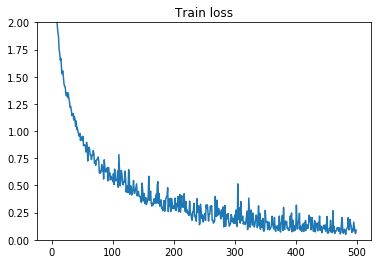

In [6]:
print("Start training...")
t = time()
for i in range(MAX_ITER):
    train_pp.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None, drop_last=True, prefetch=0)
print("Training time: {:4.2f} min".format((time() - t)/60))

plt.title('Train loss')
plt.plot(train_pp.get_variable('loss_history'))
plt.ylim((0, 2))
plt.show()

In [7]:
test_pp = (mnist.test.p
        .import_model('conv', train_pp)
        .init_variable('predictions', init_on_each_run=list)
        .predict_model('conv', fetches='UNet/predicted_proba', 
                               feed_dict={'images': B('images'),
                                          'masks': F(make_masks)},
                       save_to=V('predictions'), mode='a'))

In [8]:
print("Start testing...")
#iou = []
t = time()
for i in range(len(mnist.test.indices) // BATCH_SIZE):
    batch = test_pp.next_batch(BATCH_SIZE, shuffle=True, n_epochs=1, drop_last=True, prefetch=0)
    #iou.append(get_iou(batch, test_pp.get_variable('predictions')[-1]))
print("Testing time: {:4.2f} min".format((time() - t)/60))

#print('Test IoU: {0:.3f}'.format(np.mean(iou)))

Start testing...
Testing time: 0.39 min


In [9]:
def get_plots(images, masks, proba, n_examples=10, title=None):
    images = np.squeeze(images)
    masks = np.squeeze(masks)

    n_rows = 12
    plt.figure(figsize=(25, 2*n_examples))
    if title is not None:
        plt.suptitle(title, fontsize=26)
    for i in range(n_examples):
        plt.subplot(n_examples, n_rows, i*n_rows + 1)
        if i == 0:
            plt.title('Image')
        plt.imshow(images[i]/255, vmin=0, vmax=1, cmap='Greys')
        plt.axis('off')
        for j in range(10):
            plt.subplot(n_examples, n_rows, i*n_rows + 2 + j)
            if i == 0:
                plt.title('Mask {}'.format(j))
            plt.imshow(proba[i][:, :, j], cmap='Greys')
            plt.axis('off')

        plt.subplot(n_examples, n_rows, i*n_rows + 12)
        if i == 0:
            plt.title('Not a digit')
        plt.imshow(proba[i][:, :, -1], cmap='Greys')
        plt.axis('off')
    
    plt.subplots_adjust(bottom=0.2, right=0.8, top=0.9)
    cax = plt.axes([0.15, 0.15, 0.65, 0.01])
    plt.colorbar(cax=cax, orientation='horizontal')
    plt.show()

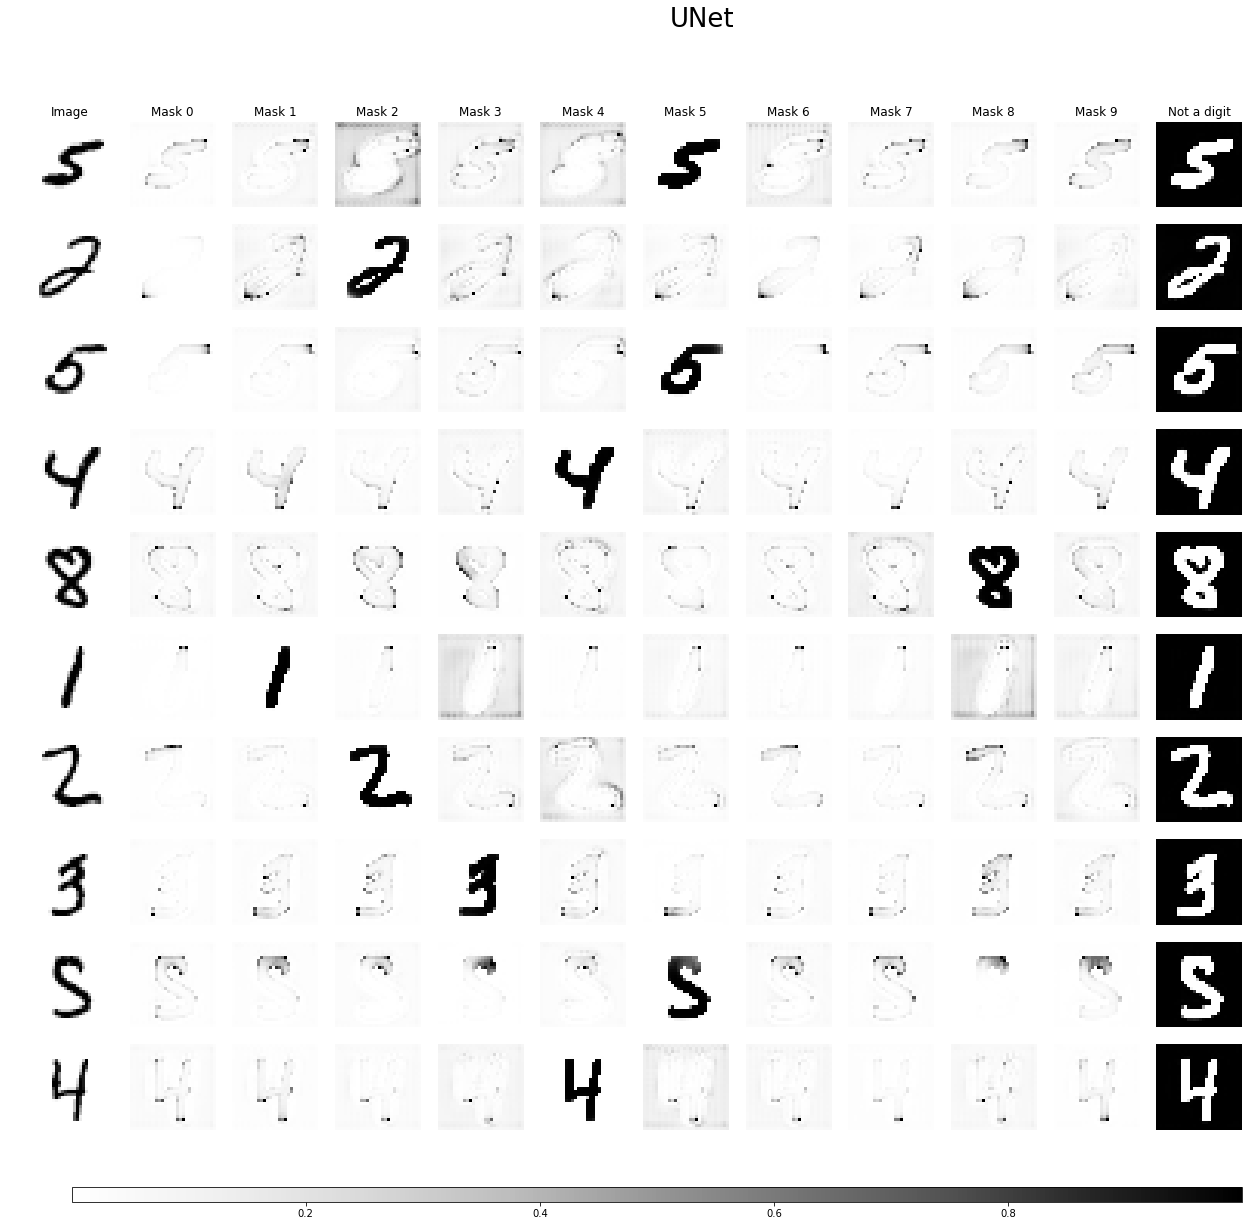

In [10]:
get_plots(batch.data.images, make_masks(batch.data), test_pp.get_variable('predictions')[-1], title='UNet')

Let's combine cells above in one function and show results of LinkNet, FCN8 and FCN32.

In [11]:
def demonstrate_model(model):
    
    train_template = (Pipeline()
            .init_variable('loss_history', init_on_each_run=list)             # pipeline variable to save loss hostory
            .init_variable('current_loss', init_on_each_run=0)                # pipeline variable for loss on batch    
            .init_model('dynamic',                                            # model type
                        model,                                                # model class
                        'conv',                                               # model name in pipeline
                        config={'loss': 'softmax_cross_entropy',              # model config
                                'optimizer': {'name':'Adam', 
                                              'use_locking': True},
                                'inputs': {'images': {'shape': (28, 28, 1)},
                                           'masks': {'shape': (28, 28), 
                                                     'classes': 11, 
                                                     'transform': 'ohe', 
                                                     'name': 'targets'}},
                                'filters': 64,
                                'num_blocks': 3,
                                'output': dict(ops=['proba'])                 # compute probability from logit output
                                })
            .train_model('conv', 
                         fetches='loss',
                         feed_dict={'images': B('images'),
                                    'masks': F(make_masks)},
                         save_to=V('current_loss'))
            .update_variable('loss_history', V('current_loss'), mode='a'))

    train_pp = (train_template << mnist.train)
    print("Start training...")
    t = time()
    for i in range(MAX_ITER):
        train_pp.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None, drop_last=True, prefetch=0)
    print("Training time: {:4.2f} min".format((time() - t)/60))
    
    plt.title('Train loss')
    plt.plot(train_pp.get_variable('loss_history'))
    plt.ylim((0, 2))
    plt.show()

    test_pp = (mnist.test.p
            .import_model('conv', train_pp)
            .init_variable('loss_history', init_on_each_run=list)             # pipeline variable to save loss hostory
            .init_variable('predictions', init_on_each_run=list)
            .predict_model('conv', fetches=['loss', model.__name__+'/predicted_proba'], 
                                   feed_dict={'images': B('images'),
                                              'masks': F(make_masks)},
                           save_to=[V('loss_history'), V('predictions')], mode='a'))

    print("Start testing...")
    iou = []
    t = time()
    for i in range(len(mnist.test.indices) // BATCH_SIZE):
        batch = test_pp.next_batch(BATCH_SIZE, shuffle=True, n_epochs=1, drop_last=True, prefetch=0)
        iou.append(get_iou(batch, test_pp.get_variable('predictions')[-1]))
    print("Testing time: {:4.2f} min".format((time() - t)/60))

    print('Test IoU: {0:.3f}'.format(np.mean(iou)))
    get_plots(batch.data.images, make_masks(batch.data), test_pp.get_variable('predictions')[-1], title=model.__name__)

Start training...
Training time: 0.71 min


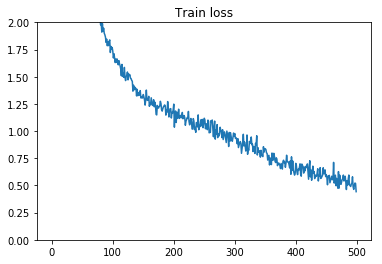

Start testing...
Testing time: 0.29 min
Test IoU: 0.001


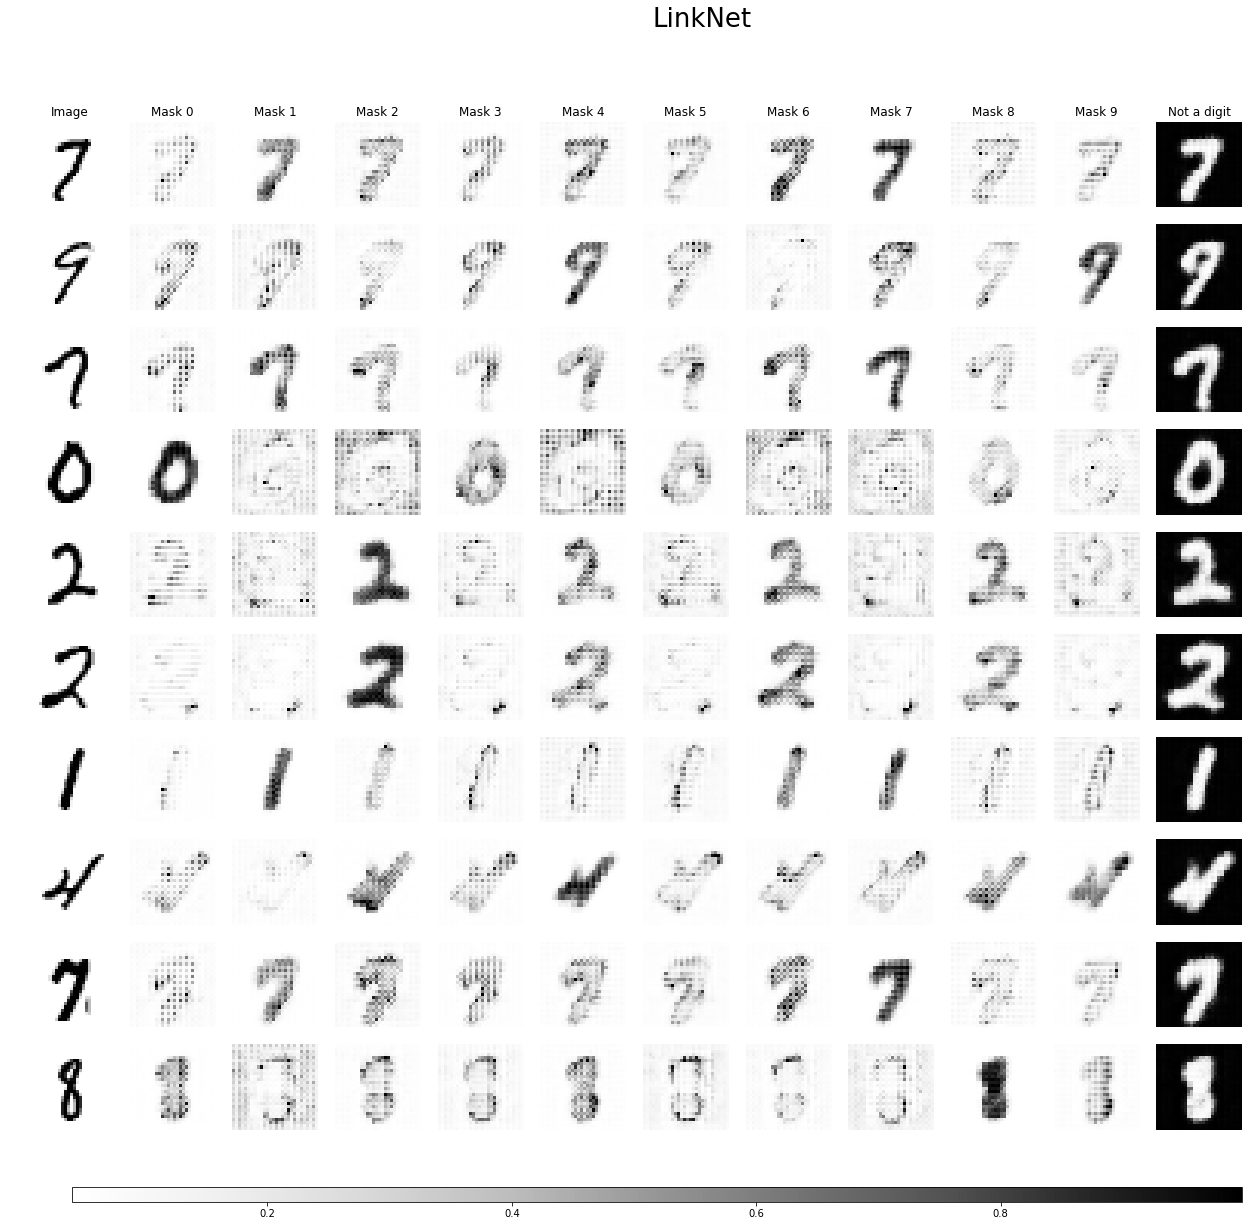

In [12]:
demonstrate_model(LinkNet)

Start training...
Training time: 1.10 min


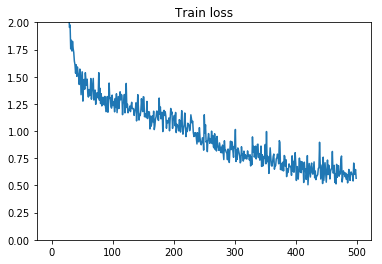

Start testing...
Testing time: 0.36 min
Test IoU: 0.011


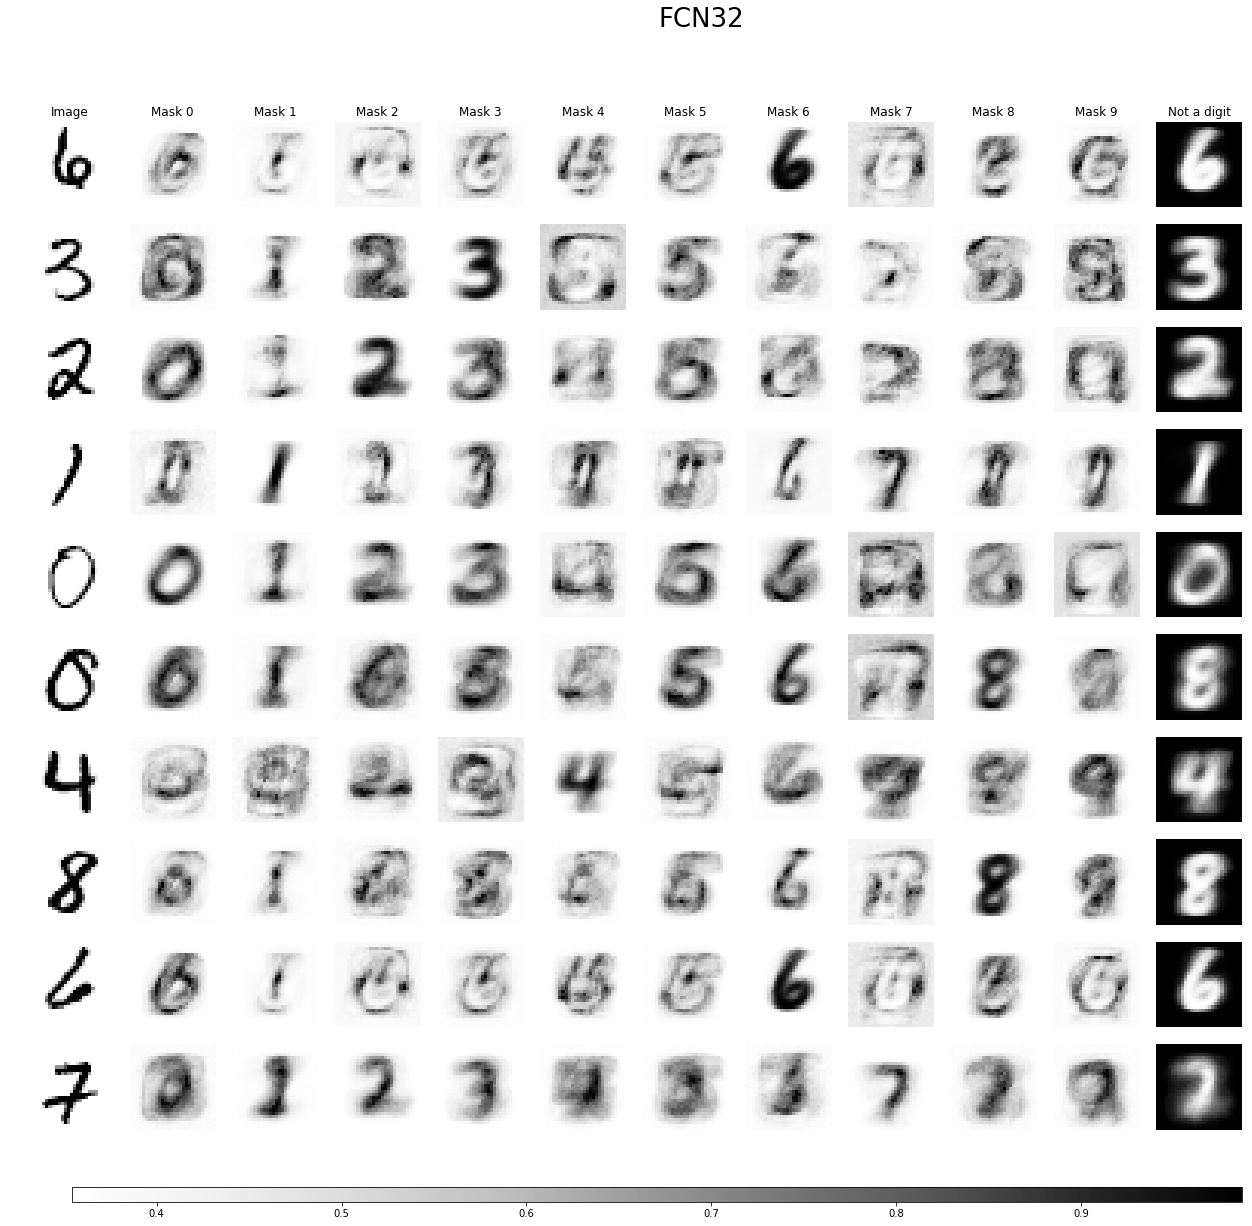

In [13]:
demonstrate_model(FCN32)

Start training...
Training time: 1.08 min


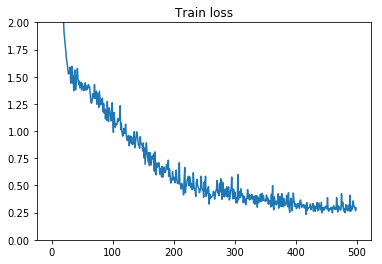

Start testing...
Testing time: 0.37 min
Test IoU: 0.011


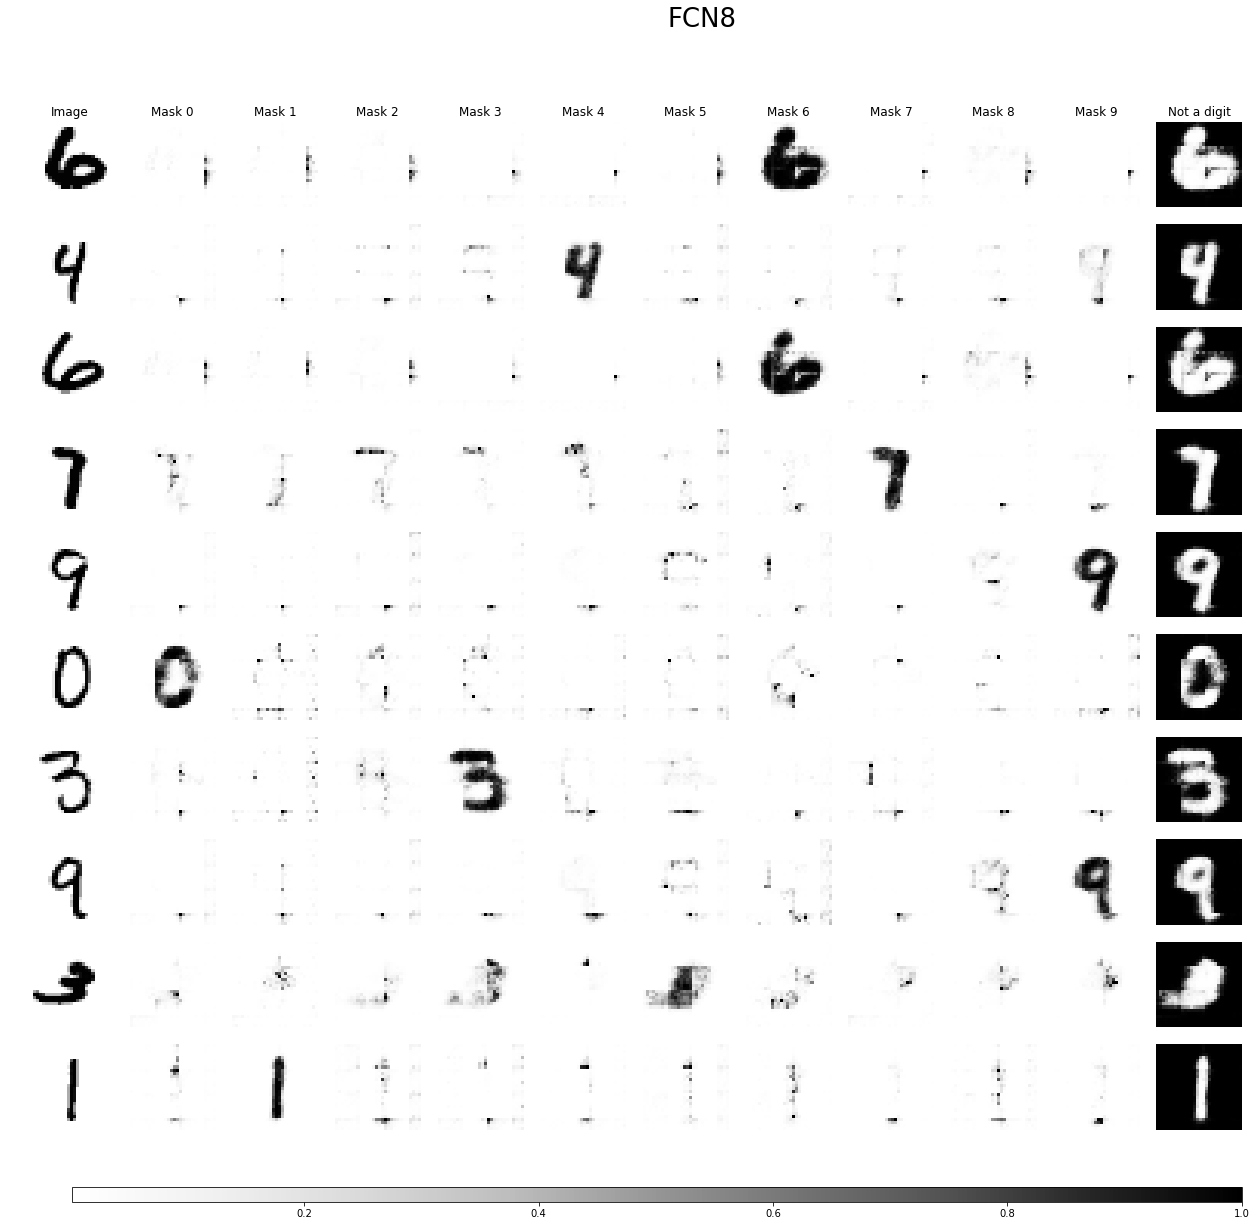

In [14]:
demonstrate_model(FCN8)